# Tennis match prediction and playing strategy -- Modeling

## Goal
1. Try different algorithms and build the prediction model, using accuracy as our evaluation metrics
    * Naive Bayes
    * Logistic Regression
    * Decision Tree
    * Random Forest
    * Support Vector Machine (linear kernel)
    * Gradient Boosting
2. Compare the performance of different feature selection methods
    * statistical-based
    * model-based
    * PCA
3. Deep learning using RNN
    * Simple RNN
    * LSTM

### Importing useful packages

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# supress warnings
import warnings
warnings.filterwarnings("ignore")

sns.set()
sns.set_style("whitegrid")

# import model package
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
import scipy.stats as stats

# import customized package
from MLuseful import get_best_model_accuracy
from MLuseful import roc_curve_plot
from MLuseful import print_confusion_matrix

### Loading data
We will load the training and testing set from the feature engineering step and we will be ready to fit the model. Recall that we have prepared two sets of data in previous notebooks, one has matches ranging from 2009-2017, with `ranking_points` feature included, another has mathces ranging from 1991-2017, without `ranking_points` feature included.

In [3]:
# load data ranging from 2009-2017, with ranking points feature included
tennis_all_feature_clean_X_train = pd.read_csv('../Processed_Data/tennis_all_feature_clean_X_train.csv')
tennis_all_feature_clean_X_test = pd.read_csv('../Processed_Data/tennis_all_feature_clean_X_test.csv')
tennis_all_feature_clean_y_train = pd.read_csv('../Processed_Data/tennis_all_feature_clean_y_train.csv', header=None)
tennis_all_feature_clean_y_test = pd.read_csv('../Processed_Data/tennis_all_feature_clean_y_test.csv', header=None)
tennis_all_feature_clean_drop_oppo_X_train = pd.read_csv('../Processed_Data/tennis_all_feature_clean_drop_oppo_X_train.csv')
tennis_all_feature_clean_drop_oppo_X_test = pd.read_csv('../Processed_Data/tennis_all_feature_clean_drop_oppo_X_test.csv')
tennis_all_feature_clean_drop_oppo_y_train = pd.read_csv('../Processed_Data/tennis_all_feature_clean_drop_oppo_y_train.csv', header=None)
tennis_all_feature_clean_drop_oppo_y_test = pd.read_csv('../Processed_Data/tennis_all_feature_clean_drop_oppo_y_test.csv', header=None)

tennis_all_feature_clean_X_train_p_value = pd.read_csv('../Processed_Data/tennis_all_feature_clean_X_train_p_value.csv')
tennis_all_feature_clean_X_test_p_value = pd.read_csv('../Processed_Data/tennis_all_feature_clean_X_test_p_value.csv')
tennis_all_feature_clean_drop_oppo_X_train_p_value = pd.read_csv('../Processed_Data/tennis_all_feature_clean_drop_oppo_X_train_p_value.csv')
tennis_all_feature_clean_drop_oppo_X_test_p_value = pd.read_csv('../Processed_Data/tennis_all_feature_clean_drop_oppo_X_test_p_value.csv')

tennis_all_feature_clean_X_train_tree = pd.read_csv('../Processed_Data/tennis_all_feature_clean_X_train_tree.csv')
tennis_all_feature_clean_X_test_tree = pd.read_csv('../Processed_Data/tennis_all_feature_clean_X_test_tree.csv')
tennis_all_feature_clean_drop_oppo_X_train_tree = pd.read_csv('../Processed_Data/tennis_all_feature_clean_drop_oppo_X_train_tree.csv')
tennis_all_feature_clean_drop_oppo_X_test_tree = pd.read_csv('../Processed_Data/tennis_all_feature_clean_drop_oppo_X_test_tree.csv')

tennis_all_feature_clean_X_train_PCA = pd.read_csv('../Processed_Data/tennis_all_feature_clean_X_train_PCA.csv')
tennis_all_feature_clean_X_test_PCA = pd.read_csv('../Processed_Data/tennis_all_feature_clean_X_test_PCA.csv')
tennis_all_feature_clean_drop_oppo_X_train_PCA = pd.read_csv('../Processed_Data/tennis_all_feature_clean_drop_oppo_X_train_PCA.csv')
tennis_all_feature_clean_drop_oppo_X_test_PCA = pd.read_csv('../Processed_Data/tennis_all_feature_clean_drop_oppo_X_test_PCA.csv')

In [10]:
# load data ranging from 1991-2017, without ranking points feature included
tennis_all_feature_no_pts_clean_X_train = pd.read_csv('../Processed_Data/tennis_all_feature_no_pts_clean_X_train.csv')
tennis_all_feature_no_pts_clean_X_test = pd.read_csv('../Processed_Data/tennis_all_feature_no_pts_clean_X_test.csv')
tennis_all_feature_no_pts_clean_y_train = pd.read_csv('../Processed_Data/tennis_all_feature_no_pts_clean_y_train.csv', header=None)
tennis_all_feature_no_pts_clean_y_test = pd.read_csv('../Processed_Data/tennis_all_feature_no_pts_clean_y_test.csv', header=None)
tennis_all_feature_no_pts_clean_drop_oppo_X_train = pd.read_csv('../Processed_Data/tennis_all_feature_no_pts_clean_drop_oppo_X_train.csv')
tennis_all_feature_no_pts_clean_drop_oppo_X_test = pd.read_csv('../Processed_Data/tennis_all_feature_no_pts_clean_drop_oppo_X_test.csv')
tennis_all_feature_no_pts_clean_drop_oppo_y_train = pd.read_csv('../Processed_Data/tennis_all_feature_no_pts_clean_drop_oppo_y_train.csv', header=None)
tennis_all_feature_no_pts_clean_drop_oppo_y_test = pd.read_csv('../Processed_Data/tennis_all_feature_no_pts_clean_drop_oppo_y_test.csv', header=None)

tennis_all_feature_no_pts_clean_X_train_p_value = pd.read_csv('../Processed_Data/tennis_all_feature_no_pts_clean_X_train_p_value.csv')
tennis_all_feature_no_pts_clean_X_test_p_value = pd.read_csv('../Processed_Data/tennis_all_feature_no_pts_clean_X_test_p_value.csv')
tennis_all_feature_no_pts_clean_drop_oppo_X_train_p_value = pd.read_csv('../Processed_Data/tennis_all_feature_no_pts_clean_drop_oppo_X_train_p_value.csv')
tennis_all_feature_no_pts_clean_drop_oppo_X_test_p_value = pd.read_csv('../Processed_Data/tennis_all_feature_no_pts_clean_drop_oppo_X_test_p_value.csv')

tennis_all_feature_no_pts_clean_X_train_tree = pd.read_csv('../Processed_Data/tennis_all_feature_no_pts_clean_X_train_tree.csv')
tennis_all_feature_no_pts_clean_X_test_tree = pd.read_csv('../Processed_Data/tennis_all_feature_no_pts_clean_X_test_tree.csv')
tennis_all_feature_no_pts_clean_drop_oppo_X_train_tree = pd.read_csv('../Processed_Data/tennis_all_feature_no_pts_clean_drop_oppo_X_train_tree.csv')
tennis_all_feature_no_pts_clean_drop_oppo_X_test_tree = pd.read_csv('../Processed_Data/tennis_all_feature_no_pts_clean_drop_oppo_X_test_tree.csv')

tennis_all_feature_no_pts_clean_X_train_PCA = pd.read_csv('../Processed_Data/tennis_all_feature_no_pts_clean_X_train_PCA.csv')
tennis_all_feature_no_pts_clean_X_test_PCA = pd.read_csv('../Processed_Data/tennis_all_feature_no_pts_clean_X_test_PCA.csv')
tennis_all_feature_no_pts_clean_drop_oppo_X_train_PCA = pd.read_csv('../Processed_Data/tennis_all_feature_no_pts_clean_drop_oppo_X_train_PCA.csv')
tennis_all_feature_no_pts_clean_drop_oppo_X_test_PCA = pd.read_csv('../Processed_Data/tennis_all_feature_no_pts_clean_drop_oppo_X_test_PCA.csv')

In [60]:
tennis_all_feature_clean_X_train.shape

(8962, 2280)

In [61]:
tennis_all_feature_clean_y_train.shape

(8962, 1)

Before fitting the model, we need to see the base score we have to beat, the base score is basically calculated by the random guessing of the majority types in outcome variable.

In [8]:
tennis_all_feature_clean_y_train[0].value_counts(normalize=True)

1    0.532582
0    0.467418
Name: 0, dtype: float64

In [11]:
tennis_all_feature_no_pts_clean_y_train[0].value_counts(normalize=True)

1    0.507147
0    0.492853
Name: 0, dtype: float64

We can see the base score we are trying to beat is 0.533 and 0.507, since if we predict every match that the player_1 is winning the current match, we will get 0.533/0.507, we will start to fit different models to find out the best in terms of fitting time, predicting accuracy...etc., we will do the grid search on hyperparameters of the algorithms and find out the best one that gives the highest accuracy.

### Traditional machine learning model

#### Naive Bayes
We will first try the simplest algorithm naive bayes, the basic assumptions of the naive bayes is the variables are independent to each other, this is more like an ideal assumption that almost never happens in the real world, but we will still see how it works since the algorithm is simple and fast.

In [62]:
# data dictionary
data_all_train = {'all_feature': tennis_all_feature_clean_X_train, 
                  'all_feature_drop_oppo': tennis_all_feature_clean_drop_oppo_X_train,
                  'all_feature_p_value': tennis_all_feature_clean_X_train_p_value, 
                  'all_feature_drop_oppo_p_value': tennis_all_feature_clean_drop_oppo_X_train_p_value,
                  'all_feature_tree': tennis_all_feature_clean_X_train_tree, 
                  'all_feature_drop_oppo_tree': tennis_all_feature_clean_drop_oppo_X_train_tree,
                  'all_feature_PCA': tennis_all_feature_clean_X_train_PCA, 
                  'all_feature_drop_oppo_PCA': tennis_all_feature_clean_drop_oppo_X_train_PCA}

In [150]:
data_all_train_no_pts = {'all_feature_no_pts': tennis_all_feature_no_pts_clean_X_train, 
                         'all_feature_no_pts_drop_oppo': tennis_all_feature_no_pts_clean_drop_oppo_X_train,
                         'all_feature_no_pts_p_value': tennis_all_feature_no_pts_clean_X_train_p_value, 
                         'all_feature_no_pts_drop_oppo_p_value': tennis_all_feature_no_pts_clean_drop_oppo_X_train_p_value,
                         'all_feature_no_pts_tree': tennis_all_feature_no_pts_clean_X_train_tree, 
                         'all_feature_no_pts_drop_oppo_tree': tennis_all_feature_no_pts_clean_drop_oppo_X_train_tree,
                         'all_feature_no_pts_PCA': tennis_all_feature_no_pts_clean_X_train_PCA, 
                         'all_feature_no_pts_drop_oppo_PCA': tennis_all_feature_no_pts_clean_drop_oppo_X_train_PCA}

In [13]:
# create a new dictionary to collect all the score and all the best parameters
all_score = {}
all_params = {}
all_score_no_pts = {}
all_params_no_pts = {}

In [64]:
# matches ranging from 2009-2017, included ranking_points features
naive = GaussianNB()

# create an empty list to store the scores of naive bayes algorithms
all_score['Naive_Bayes'] = []
all_params['Naive_Bayes'] = []
# specify the hyperparameters we are going to do gridsearch on
naive_params = {'var_smoothing': [1e-11, 1e-10, 1e-9, 1e-8, 1e-7]}
for name, data in data_all_train.items():
    print(name)
    print(f'training set size: {data.shape}')
    print('-'*90)
    best, score = get_best_model_accuracy(naive, naive_params, data, tennis_all_feature_clean_y_train, score='accuracy')
    all_score['Naive_Bayes'].append(score)
    all_params['Naive_Bayes'].append(best)
    print('\n')

all_feature
training set size: (8962, 2280)
------------------------------------------------------------------------------------------
Best accuracy : 0.7007364427583129
Best Parameters: {'var_smoothing': 1e-11}
Average Time to Fit (s): 0.678
Average Time to Score (s): 0.125


all_feature_drop_oppo
training set size: (8962, 1540)
------------------------------------------------------------------------------------------
Best accuracy : 0.6967194822584245
Best Parameters: {'var_smoothing': 1e-11}
Average Time to Fit (s): 0.419
Average Time to Score (s): 0.081


all_feature_p_value
training set size: (8962, 500)
------------------------------------------------------------------------------------------
Best accuracy : 0.7194822584244588
Best Parameters: {'var_smoothing': 1e-11}
Average Time to Fit (s): 0.125
Average Time to Score (s): 0.024


all_feature_drop_oppo_p_value
training set size: (8962, 500)
----------------------------------------------------------------------------------------

Interestingly, the data prepared using PCA outbeat the other in this case, the one with all the features did not show any advantage. Plus the modeling fitting time of PCA-processed data is a lot faster due to less features. The reason behind that the PCA outperformed the rest might be due to the assumption of Naive Bayes is the features are independant to each outher and all the components generated from PCA are orthogonal to each other in N-dimensional hyperplane.

In [14]:
# matches ranging from 1991-2017, without including ranking_points features
naive = GaussianNB()

# create an empty list to store the scores of naive bayes algorithms
all_score_no_pts['Naive_Bayes'] = []
all_params_no_pts['Naive_Bayes'] = []
# specify the hyperparameters we are going to do gridsearch on
naive_params = {'var_smoothing': [1e-11, 1e-10, 1e-9, 1e-8, 1e-7]}
for name, data in data_all_train_no_pts.items():
    print(name)
    print(f'training set size: {data.shape}')
    print('-'*90)
    best, score = get_best_model_accuracy(naive, naive_params, data, tennis_all_feature_no_pts_clean_y_train, score='accuracy')
    all_score_no_pts['Naive_Bayes'].append(score)
    all_params_no_pts['Naive_Bayes'].append(best)
    print('\n')

all_feature_no_pts
training set size: (5247, 2220)
------------------------------------------------------------------------------------------
Best accuracy : 0.6565656565656566
Best Parameters: {'var_smoothing': 1e-11}
Average Time to Fit (s): 0.358
Average Time to Score (s): 0.071


all_feature_no_pts_drop_oppo
training set size: (5247, 1500)
------------------------------------------------------------------------------------------
Best accuracy : 0.6660949113779302
Best Parameters: {'var_smoothing': 1e-11}
Average Time to Fit (s): 0.237
Average Time to Score (s): 0.048


all_feature_no_pts_p_value
training set size: (5247, 500)
------------------------------------------------------------------------------------------
Best accuracy : 0.6809605488850772
Best Parameters: {'var_smoothing': 1e-11}
Average Time to Fit (s): 0.065
Average Time to Score (s): 0.012


all_feature_no_pts_drop_oppo_p_value
training set size: (5247, 500)
------------------------------------------------------------

In general, losing `ranking_points` feature has reduced the performance of naive bayes in this case, since the range of the match is much wider, it could introduced more bias.

#### Logistic Regression
Now we will try the logistic regression, this is a more complicated algorithms than the previous two, it basically utilize the sigmoid function to calculate the probability of an example and use it to predict the outcome value, the default probability is set to be 0.5, when the hypothesis is greater or equal to 0.5, it will predict 1 and 0 otherwise.

In [65]:
# matches ranging from 2009-2017, included ranking_points features
lgr = LogisticRegression()

# create an empty list to store the scores of logistic regress algorithms
all_score['Logistic_regression'] = []
all_params['Logistic_regression'] = []
lgr_params = {'penalty': ['l1', 'l2'],
              'C': [0.01, 0.1, 1, 10]}

for name, data in data_all_train.items():
    print(name)
    print(f'training set size: {data.shape}')
    print('-'*90)
    best, score = get_best_model_accuracy(lgr, lgr_params, data, tennis_all_feature_clean_y_train, score='accuracy')
    all_score['Logistic_regression'].append(score)
    all_params['Logistic_regression'].append(best)
    print('\n')

all_feature
training set size: (8962, 2280)
------------------------------------------------------------------------------------------
Best accuracy : 0.8975675072528454
Best Parameters: {'C': 0.01, 'penalty': 'l1'}
Average Time to Fit (s): 26.592
Average Time to Score (s): 0.022


all_feature_drop_oppo
training set size: (8962, 1540)
------------------------------------------------------------------------------------------
Best accuracy : 0.8984601651417095
Best Parameters: {'C': 0.01, 'penalty': 'l1'}
Average Time to Fit (s): 21.789
Average Time to Score (s): 0.015


all_feature_p_value
training set size: (8962, 500)
------------------------------------------------------------------------------------------
Best accuracy : 0.8629770140593618
Best Parameters: {'C': 0.1, 'penalty': 'l1'}
Average Time to Fit (s): 4.742
Average Time to Score (s): 0.004


all_feature_drop_oppo_p_value
training set size: (8962, 500)
---------------------------------------------------------------------------

It looks like the model-based selection works out the best in logistic regression, it only contains 500 features but are able to reach the accuracy score that is close to using 2280 and 1540 features, this suggested most of our features might be redundant. One big advantage of using less feature is the time to train the model, while the top two dataset took average more than 20 secs to fit the model, the dataset after feature selection only requires around 5 secs, if the time is really a concern, using PCA is another good option since it only took no more than 3 secs on average and still able to reach a pretty good accuracy.

In [15]:
# matches ranging from 1991-2017, without including ranking_points features
lgr = LogisticRegression()

# create an empty list to store the scores of logistic regress algorithms
all_score_no_pts['Logistic_regression'] = []
all_params_no_pts['Logistic_regression'] = []
lgr_params = {'penalty': ['l1', 'l2'],
              'C': [0.01, 0.1, 1, 10]}

for name, data in data_all_train_no_pts.items():
    print(name)
    print(f'training set size: {data.shape}')
    print('-'*90)
    best, score = get_best_model_accuracy(lgr, lgr_params, data, tennis_all_feature_no_pts_clean_y_train, score='accuracy')
    all_score_no_pts['Logistic_regression'].append(score)
    all_params_no_pts['Logistic_regression'].append(best)
    print('\n')

all_feature_no_pts
training set size: (5247, 2220)
------------------------------------------------------------------------------------------
Best accuracy : 0.9125214408233276
Best Parameters: {'C': 0.01, 'penalty': 'l1'}
Average Time to Fit (s): 19.382
Average Time to Score (s): 0.014


all_feature_no_pts_drop_oppo
training set size: (5247, 1500)
------------------------------------------------------------------------------------------
Best accuracy : 0.9125214408233276
Best Parameters: {'C': 0.01, 'penalty': 'l1'}
Average Time to Fit (s): 16.314
Average Time to Score (s): 0.009


all_feature_no_pts_p_value
training set size: (5247, 500)
------------------------------------------------------------------------------------------
Best accuracy : 0.8604917095483133
Best Parameters: {'C': 0.01, 'penalty': 'l1'}
Average Time to Fit (s): 3.236
Average Time to Score (s): 0.003


all_feature_no_pts_drop_oppo_p_value
training set size: (5247, 500)
----------------------------------------------

As we seen from the result above, without `ranking_points` dataset outperformed the dataset with `ranking_points` in logistic regression, the accuracy could reach more than 90%! Same as previously, the model-based feature selection data have reached comparable accuracy score as using all features, this suggested there might be a lot of redundant features that we could get rid of.

#### Decision tree
We will now test our tree model, this algorithm is different from previous models we fit, it basically uses a certain criteria to separate the data into two groups in each branch, the criteria is based on the maximum information gain.

In [66]:
# matches ranging from 2009-2017, included ranking_points features
dt = DecisionTreeClassifier()

# create an empty list to store the scores of tree algorithms
all_score['Decision_tree'] = []
all_params['Decision_tree'] = []

dt_params = {'criterion': ['gini', 'entropy'],
             'max_depth': [1,3,5,7,9,11],}

for name, data in data_all_train.items():
    print(name)
    print(f'training set size: {data.shape}')
    print('-'*90)
    best, score = get_best_model_accuracy(dt, dt_params, data, tennis_all_feature_clean_y_train, score='accuracy')
    all_score['Decision_tree'].append(score)
    all_params['Decision_tree'].append(best)
    print('\n')

all_feature
training set size: (8962, 2280)
------------------------------------------------------------------------------------------
Best accuracy : 0.8821691586699397
Best Parameters: {'criterion': 'entropy', 'max_depth': 7}
Average Time to Fit (s): 4.584
Average Time to Score (s): 0.027


all_feature_drop_oppo
training set size: (8962, 1540)
------------------------------------------------------------------------------------------
Best accuracy : 0.8811649185449676
Best Parameters: {'criterion': 'gini', 'max_depth': 7}
Average Time to Fit (s): 3.157
Average Time to Score (s): 0.019


all_feature_p_value
training set size: (8962, 500)
------------------------------------------------------------------------------------------
Best accuracy : 0.8580673956706092
Best Parameters: {'criterion': 'entropy', 'max_depth': 7}
Average Time to Fit (s): 1.306
Average Time to Score (s): 0.005


all_feature_drop_oppo_p_value
training set size: (8962, 500)
-------------------------------------------

Same as logistic regression, the decision tree model seems to pick up the most important features that were selected by the model-based method, using more than 1500 of features did not help much in this case either, this again proved that some of the features might be redundant. PCA did not seem to be compatible with tree model, existing a high bias.

In [16]:
# matches ranging from 1991-2017, without including ranking_points features
dt = DecisionTreeClassifier()

# create an empty list to store the scores of tree algorithms
all_score_no_pts['Decision_tree'] = []
all_params_no_pts['Decision_tree'] = []

dt_params = {'criterion': ['gini', 'entropy'],
             'max_depth': [1,3,5,7,9,11],}

for name, data in data_all_train_no_pts.items():
    print(name)
    print(f'training set size: {data.shape}')
    print('-'*90)
    best, score = get_best_model_accuracy(dt, dt_params, data, tennis_all_feature_no_pts_clean_y_train, score='accuracy')
    all_score_no_pts['Decision_tree'].append(score)
    all_params_no_pts['Decision_tree'].append(best)
    print('\n')

all_feature_no_pts
training set size: (5247, 2220)
------------------------------------------------------------------------------------------
Best accuracy : 0.8867924528301887
Best Parameters: {'criterion': 'gini', 'max_depth': 7}
Average Time to Fit (s): 2.45
Average Time to Score (s): 0.015


all_feature_no_pts_drop_oppo
training set size: (5247, 1500)
------------------------------------------------------------------------------------------
Best accuracy : 0.8877453783114161
Best Parameters: {'criterion': 'gini', 'max_depth': 7}
Average Time to Fit (s): 1.668
Average Time to Score (s): 0.01


all_feature_no_pts_p_value
training set size: (5247, 500)
------------------------------------------------------------------------------------------
Best accuracy : 0.8547741566609491
Best Parameters: {'criterion': 'gini', 'max_depth': 5}
Average Time to Fit (s): 0.753
Average Time to Score (s): 0.004


all_feature_no_pts_drop_oppo_p_value
training set size: (5247, 500)
-----------------------

Decision tree performed similar no matter using `ranking_points` feature or not. The PCA data still performed badly here.

#### Random forest

In [67]:
# matches ranging from 2009-2017, included ranking_points features
rf = RandomForestClassifier()

# create an empty list to store the scores of tree algorithms
all_score['Random_forest'] = []
all_params['Random_forest'] = []

rf_params = {'n_estimators': [10, 50, 100, 500],
             'max_depth': [1,3,5,7,9]}

for name, data in data_all_train.items():
    print(name)
    print(f'training set size: {data.shape}')
    print('-'*90)
    best, score = get_best_model_accuracy(rf, rf_params, data, tennis_all_feature_clean_y_train, score='accuracy')
    all_score['Random_forest'].append(score)
    all_params['Random_forest'].append(best)
    print('\n')

all_feature
training set size: (8962, 2280)
------------------------------------------------------------------------------------------
Best accuracy : 0.8406605668377595
Best Parameters: {'max_depth': 9, 'n_estimators': 500}
Average Time to Fit (s): 8.301
Average Time to Score (s): 0.07


all_feature_drop_oppo
training set size: (8962, 1540)
------------------------------------------------------------------------------------------
Best accuracy : 0.8350814550323589
Best Parameters: {'max_depth': 9, 'n_estimators': 500}
Average Time to Fit (s): 7.032
Average Time to Score (s): 0.063


all_feature_p_value
training set size: (8962, 500)
------------------------------------------------------------------------------------------
Best accuracy : 0.8694487837536264
Best Parameters: {'max_depth': 9, 'n_estimators': 500}
Average Time to Fit (s): 4.956
Average Time to Score (s): 0.047


all_feature_drop_oppo_p_value
training set size: (8962, 500)
--------------------------------------------------

Compare to decision tree model we ran previously, random forest performed worse and also it took much more time to train the model. This could be explained by the algorithm nature of random forest, which took random tree for each estimator and average out the result, each tree composed of different patches that used different subset of features in training example, since we have thousands of features, everytime it could have picked the features that are relatively not important and provide less information to the predicting model, thus the overall performance was not as good as decision tree.

In [17]:
rf = RandomForestClassifier()
# matches ranging from 1991-2017, without including ranking_points features
# create an empty list to store the scores of tree algorithms
all_score_no_pts['Random_forest'] = []
all_params_no_pts['Random_forest'] = []

rf_params = {'n_estimators': [10, 50, 100, 500],
             'max_depth': [1,3,5,7,9]}

for name, data in data_all_train_no_pts.items():
    print(name)
    print(f'training set size: {data.shape}')
    print('-'*90)
    best, score = get_best_model_accuracy(rf, rf_params, data, tennis_all_feature_no_pts_clean_y_train, score='accuracy')
    all_score_no_pts['Random_forest'].append(score)
    all_params_no_pts['Random_forest'].append(best)
    print('\n')

all_feature_no_pts
training set size: (5247, 2220)
------------------------------------------------------------------------------------------
Best accuracy : 0.8332380407852106
Best Parameters: {'max_depth': 9, 'n_estimators': 500}
Average Time to Fit (s): 4.962
Average Time to Score (s): 0.049


all_feature_no_pts_drop_oppo
training set size: (5247, 1500)
------------------------------------------------------------------------------------------
Best accuracy : 0.8280922431865828
Best Parameters: {'max_depth': 9, 'n_estimators': 500}
Average Time to Fit (s): 4.03
Average Time to Score (s): 0.044


all_feature_no_pts_p_value
training set size: (5247, 500)
------------------------------------------------------------------------------------------
Best accuracy : 0.8540118162759672
Best Parameters: {'max_depth': 9, 'n_estimators': 500}
Average Time to Fit (s): 2.798
Average Time to Score (s): 0.033


all_feature_no_pts_drop_oppo_p_value
training set size: (5247, 500)
----------------------

Random forest algorithm did not show any difference whether including `ranking_points` features or not, and again, it performed worse than decision tree as the reason we described.

#### Support vector machine
We will next try the support vector machine, this algorithms has a cost function that is modified from logistic regression, the modified version of cost function creates an ideal hyperplance in an n-dimensional space that separates the class with the maximum margin, we will first try the linear support vector machine

In [68]:
# linear support vector machine
# matches ranging from 2009-2017, included ranking_points features
lsvc = LinearSVC()

# create an empty list to store the scores of linear support vector machine algorithms
all_score['LSVM'] = []
all_params['LSVM'] = []
lsvc_params = {'C': [0.01, 0.1, 1, 10, 100],
               'penalty': ['l1', 'l2']}
for name, data in data_all_train.items():
    print(name)
    print(f'training set size: {data.shape}')
    print('-'*90)
    best, score = get_best_model_accuracy(lsvc, lsvc_params, data, tennis_all_feature_clean_y_train, score='accuracy')
    all_score['LSVM'].append(score)
    all_params['LSVM'].append(best)
    print('\n')

all_feature
training set size: (8962, 2280)
------------------------------------------------------------------------------------------
Best accuracy : 0.874916313322919
Best Parameters: {'C': 0.01, 'penalty': 'l2'}
Average Time to Fit (s): 12.103
Average Time to Score (s): 0.011


all_feature_drop_oppo
training set size: (8962, 1540)
------------------------------------------------------------------------------------------
Best accuracy : 0.8769247935728632
Best Parameters: {'C': 0.01, 'penalty': 'l2'}
Average Time to Fit (s): 8.018
Average Time to Score (s): 0.008


all_feature_p_value
training set size: (8962, 500)
------------------------------------------------------------------------------------------
Best accuracy : 0.8540504351707208
Best Parameters: {'C': 0.01, 'penalty': 'l2'}
Average Time to Fit (s): 3.55
Average Time to Score (s): 0.002


all_feature_drop_oppo_p_value
training set size: (8962, 500)
-----------------------------------------------------------------------------

We can see that from linear support vector machine model, using all the features again did not perform better than the model-based selection data, it also took much more time to train the model.

In [18]:
# linear support vector machine
# matches ranging from 1991-2017, without including ranking_points features
lsvc = LinearSVC()

# create an empty list to store the scores of linear support vector machine algorithms
all_score_no_pts['LSVM'] = []
all_params_no_pts['LSVM'] = []
lsvc_params = {'C': [0.01, 0.1, 1, 10, 100],
               'penalty': ['l1', 'l2']}
for name, data in data_all_train_no_pts.items():
    print(name)
    print(f'training set size: {data.shape}')
    print('-'*90)
    best, score = get_best_model_accuracy(lsvc, lsvc_params, data, tennis_all_feature_no_pts_clean_y_train, score='accuracy')
    all_score_no_pts['LSVM'].append(score)
    all_params_no_pts['LSVM'].append(best)
    print('\n')

all_feature_no_pts
training set size: (5247, 2220)
------------------------------------------------------------------------------------------
Best accuracy : 0.876882027825424
Best Parameters: {'C': 0.01, 'penalty': 'l2'}
Average Time to Fit (s): 5.026
Average Time to Score (s): 0.006


all_feature_no_pts_drop_oppo
training set size: (5247, 1500)
------------------------------------------------------------------------------------------
Best accuracy : 0.8816466552315609
Best Parameters: {'C': 0.01, 'penalty': 'l2'}
Average Time to Fit (s): 3.358
Average Time to Score (s): 0.005


all_feature_no_pts_p_value
training set size: (5247, 500)
------------------------------------------------------------------------------------------
Best accuracy : 0.8450543167524299
Best Parameters: {'C': 0.01, 'penalty': 'l2'}
Average Time to Fit (s): 1.905
Average Time to Score (s): 0.001


all_feature_no_pts_drop_oppo_p_value
training set size: (5247, 500)
-------------------------------------------------

The `all_feature_no_pts_drop_oppo_tree` data reaches over 90% of accuracy with only around 1.6 second training time, the previous model that reached over 90% accuracy required nearly 3 seconds in logistic regression. The other data did not show much difference whether using `ranking_points` feature or not. 

#### Gradient bossting

In [69]:
# matches ranging from 2009-2017, included ranking_points features
gbr = GradientBoostingClassifier()

# create an empty list to store the scores of gradient boosting algorithms
all_score['Gradient_boosting'] = []
all_params['Gradient_boosting'] = []
gbr_params = {'learning_rate': [0.05, 0.1, 0.5]}

for name, data in data_all_train.items():
    print(name)
    print(f'training set size: {data.shape}')
    print('-'*90)
    best, score = get_best_model_accuracy(gbr, gbr_params, data, tennis_all_feature_clean_y_train, score='accuracy')
    all_score['Gradient_boosting'].append(score)
    all_params['Gradient_boosting'].append(best)
    print('\n')

all_feature
training set size: (8962, 2280)
------------------------------------------------------------------------------------------
Best accuracy : 0.9163133229189913
Best Parameters: {'learning_rate': 0.1}
Average Time to Fit (s): 73.559
Average Time to Score (s): 0.069


all_feature_drop_oppo
training set size: (8962, 1540)
------------------------------------------------------------------------------------------
Best accuracy : 0.9170943985717473
Best Parameters: {'learning_rate': 0.1}
Average Time to Fit (s): 50.772
Average Time to Score (s): 0.047


all_feature_p_value
training set size: (8962, 500)
------------------------------------------------------------------------------------------
Best accuracy : 0.8862977014059362
Best Parameters: {'learning_rate': 0.1}
Average Time to Fit (s): 20.07
Average Time to Score (s): 0.013


all_feature_drop_oppo_p_value
training set size: (8962, 500)
------------------------------------------------------------------------------------------
B

We can see that gradient boosting is so far the only algorithm that could reach the accuracy more than 92% using different dataset, however, the training time required was a lot higher than others that had slightly lower accuracy but faster training time.

In [19]:
# matches ranging from 1991-2017, without including ranking_points features
gbr = GradientBoostingClassifier()

# create an empty list to store the scores of gradient boosting algorithms
all_score_no_pts['Gradient_boosting'] = []
all_params_no_pts['Gradient_boosting'] = []
gbr_params = {'learning_rate': [0.05, 0.1, 0.5]}

for name, data in data_all_train_no_pts.items():
    print(name)
    print(f'training set size: {data.shape}')
    print('-'*90)
    best, score = get_best_model_accuracy(gbr, gbr_params, data, tennis_all_feature_no_pts_clean_y_train, score='accuracy')
    all_score_no_pts['Gradient_boosting'].append(score)
    all_params_no_pts['Gradient_boosting'].append(best)
    print('\n')

all_feature_no_pts
training set size: (5247, 2220)
------------------------------------------------------------------------------------------
Best accuracy : 0.9214789403468648
Best Parameters: {'learning_rate': 0.1}
Average Time to Fit (s): 46.088
Average Time to Score (s): 0.044


all_feature_no_pts_drop_oppo
training set size: (5247, 1500)
------------------------------------------------------------------------------------------
Best accuracy : 0.9226224509243377
Best Parameters: {'learning_rate': 0.1}
Average Time to Fit (s): 32.434
Average Time to Score (s): 0.03


all_feature_no_pts_p_value
training set size: (5247, 500)
------------------------------------------------------------------------------------------
Best accuracy : 0.88126548503907
Best Parameters: {'learning_rate': 0.1}
Average Time to Fit (s): 13.68
Average Time to Score (s): 0.009


all_feature_no_pts_drop_oppo_p_value
training set size: (5247, 500)
-------------------------------------------------------------------

Without using `ranking_points` feature, we can see that the accuracy was about the same and model-based feature selection was still able to reach accuracy more than 92%. But again, the training time was a lot longer.

### Summary of the scores
We have gathered all the scores and best parameters from our model we trained and we will show the summary table as the following:

#### matches from 2009-2017, with `ranking_points` feature included.

In [78]:
all_score_df = pd.DataFrame(all_score, index=['all_feature', 'all_feature_drop_oppo', 'all_feature_p_value',
                                              'all_feature_drop_oppo_p_value', 'all_feature_tree',
                                              'all_feature_drop_oppo_tree', 'all_feature_PCA',
                                              'all_feature_drop_oppo_PCA'])
all_score_df['Avg_score'] = all_score_df.mean(axis=1)
all_score_df

,Naive_Bayes,Logistic_regression,Decision_tree,Random_forest,LSVM,Gradient_boosting,Avg_score
all_feature,0.700736,0.897568,0.882169,0.840661,0.874916,0.916313,0.852061
all_feature_drop_oppo,0.696719,0.898460,0.881165,0.835081,0.876925,0.917094,0.850908
all_feature_p_value,0.719482,0.862977,0.858067,0.869449,0.854050,0.886298,0.841721
all_feature_drop_oppo_p_value,0.704530,0.858402,0.861526,0.852935,0.847244,0.882615,0.834542
all_feature_tree,0.708547,0.897010,0.885405,0.857063,0.889534,0.916536,0.859016
all_feature_drop_oppo_tree,0.697501,0.895336,0.884401,0.862754,0.889422,0.918768,0.858030
all_feature_PCA,0.811649,0.878599,0.629435,0.721602,0.877260,0.771703,0.781708
all_feature_drop_oppo_PCA,0.813100,0.879491,0.632894,0.708436,0.880607,0.750614,0.777524


In [79]:
all_params_df = pd.DataFrame(all_params, index=['all_feature', 'all_feature_drop_oppo', 'all_feature_p_value',
                                              'all_feature_drop_oppo_p_value', 'all_feature_tree',
                                              'all_feature_drop_oppo_tree', 'all_feature_PCA',
                                              'all_feature_drop_oppo_PCA'])
all_params_df

,Naive_Bayes,Logistic_regression,Decision_tree,Random_forest,LSVM,Gradient_boosting
all_feature,{'var_smoothing': 1e-11},"{'C': 0.01, 'penalty': 'l1'}","{'criterion': 'entropy', 'max_depth': 7}","{'max_depth': 9, 'n_estimators': 500}","{'C': 0.01, 'penalty': 'l2'}",{'learning_rate': 0.1}
all_feature_drop_oppo,{'var_smoothing': 1e-11},"{'C': 0.01, 'penalty': 'l1'}","{'criterion': 'gini', 'max_depth': 7}","{'max_depth': 9, 'n_estimators': 500}","{'C': 0.01, 'penalty': 'l2'}",{'learning_rate': 0.1}
all_feature_p_value,{'var_smoothing': 1e-11},"{'C': 0.1, 'penalty': 'l1'}","{'criterion': 'entropy', 'max_depth': 7}","{'max_depth': 9, 'n_estimators': 500}","{'C': 0.01, 'penalty': 'l2'}",{'learning_rate': 0.1}
all_feature_drop_oppo_p_value,{'var_smoothing': 1e-11},"{'C': 0.1, 'penalty': 'l1'}","{'criterion': 'gini', 'max_depth': 5}","{'max_depth': 9, 'n_estimators': 500}","{'C': 0.01, 'penalty': 'l2'}",{'learning_rate': 0.1}
all_feature_tree,{'var_smoothing': 1e-11},"{'C': 0.01, 'penalty': 'l1'}","{'criterion': 'gini', 'max_depth': 9}","{'max_depth': 9, 'n_estimators': 500}","{'C': 0.01, 'penalty': 'l2'}",{'learning_rate': 0.1}
all_feature_drop_oppo_tree,{'var_smoothing': 1e-11},"{'C': 0.1, 'penalty': 'l1'}","{'criterion': 'gini', 'max_depth': 7}","{'max_depth': 9, 'n_estimators': 500}","{'C': 0.01, 'penalty': 'l2'}",{'learning_rate': 0.1}
all_feature_PCA,{'var_smoothing': 1e-11},"{'C': 0.1, 'penalty': 'l1'}","{'criterion': 'entropy', 'max_depth': 5}","{'max_depth': 9, 'n_estimators': 500}","{'C': 0.01, 'penalty': 'l2'}",{'learning_rate': 0.5}
all_feature_drop_oppo_PCA,{'var_smoothing': 1e-11},"{'C': 0.01, 'penalty': 'l2'}","{'criterion': 'entropy', 'max_depth': 5}","{'max_depth': 9, 'n_estimators': 500}","{'C': 0.01, 'penalty': 'l2'}",{'learning_rate': 0.5}


In [80]:
# average score by algorithm
all_score_df.mean().sort_values(ascending=False)

Logistic_regression    0.883480
LSVM                   0.873745
Gradient_boosting      0.869993
Avg_score              0.831939
Random_forest          0.818498
Decision_tree          0.814383
Naive_Bayes            0.731533
dtype: float64

In [81]:
# average score by type of data
all_score_df['Avg_score'].sort_values(ascending=False)

all_feature_tree                 0.859016
all_feature_drop_oppo_tree       0.858030
all_feature                      0.852061
all_feature_drop_oppo            0.850908
all_feature_p_value              0.841721
all_feature_drop_oppo_p_value    0.834542
all_feature_PCA                  0.781708
all_feature_drop_oppo_PCA        0.777524
Name: Avg_score, dtype: float64

We can see from above that logistic regression had more consistent performance no matter which dataset we used to train, gradient boosting was the only algorithm that reaches more than 90% accuracy, however the time to train the model was relatively long. We will pick up the three best in each algorithm and use the best hyperparameters we have tuned to fit the test set.

##### Test set performance

In [85]:
# test set data dictionary
data_all_test = {'all_feature': tennis_all_feature_clean_X_test, 
                 'all_feature_drop_oppo': tennis_all_feature_clean_drop_oppo_X_test,
                 'all_feature_p_value': tennis_all_feature_clean_X_test_p_value, 
                 'all_feature_drop_oppo_p_value': tennis_all_feature_clean_drop_oppo_X_test_p_value,
                 'all_feature_tree': tennis_all_feature_clean_X_test_tree, 
                 'all_feature_drop_oppo_tree': tennis_all_feature_clean_drop_oppo_X_test_tree,
                 'all_feature_PCA': tennis_all_feature_clean_X_test_PCA, 
                 'all_feature_drop_oppo_PCA': tennis_all_feature_clean_drop_oppo_X_test_PCA}

# algorithm dictionary
algorithm = {'Naive_Bayes': GaussianNB, 'Logistic_regression': LogisticRegression, 
        'Decision_tree': DecisionTreeClassifier, 'Random_forest': RandomForestClassifier, 
        'LSVM': LinearSVC, 'Gradient_boosting': GradientBoostingClassifier}

# test score dictionary
test_score = {}

In [86]:
# define helper function
def test_accuracy(algo, top=2): # use the top 2 algorithms as default
    from sklearn.metrics import accuracy_score
    rank = all_score_df.rank(method='first', ascending=False) # get the ranking of data in each algorithm
    for data in rank[algo][rank[algo] <= top].index: # pick only the highest two
        model = algorithm[algo](**all_params_df.loc[data, algo]) # fit the model with the best parameters
        model.fit(data_all_train[data], tennis_all_feature_clean_y_train)
        score = accuracy_score(tennis_all_feature_clean_y_test, model.predict(data_all_test[data]))
        test_score[algo+'_'+data] = round(score,5)

In [97]:
for algo in algorithm:
    test_accuracy(algo, top=3)

In [98]:
# create a dataframe to list all the score
all_test_df = pd.DataFrame(test_score, index=['test_score'])
all_test_df = all_test_df.T.sort_values(by='test_score', ascending=False)
all_test_df

,test_score
Gradient_boosting_all_feature_drop_oppo,0.92816
Gradient_boosting_all_feature_drop_oppo_tree,0.92764
Gradient_boosting_all_feature_tree,0.92582
Logistic_regression_all_feature_tree,0.90213
Logistic_regression_all_feature,0.90109
Logistic_regression_all_feature_drop_oppo,0.90083
LSVM_all_feature_tree,0.89719
Decision_tree_all_feature_drop_oppo_tree,0.89276
LSVM_all_feature_drop_oppo_tree,0.89068
Decision_tree_all_feature_tree,0.88704


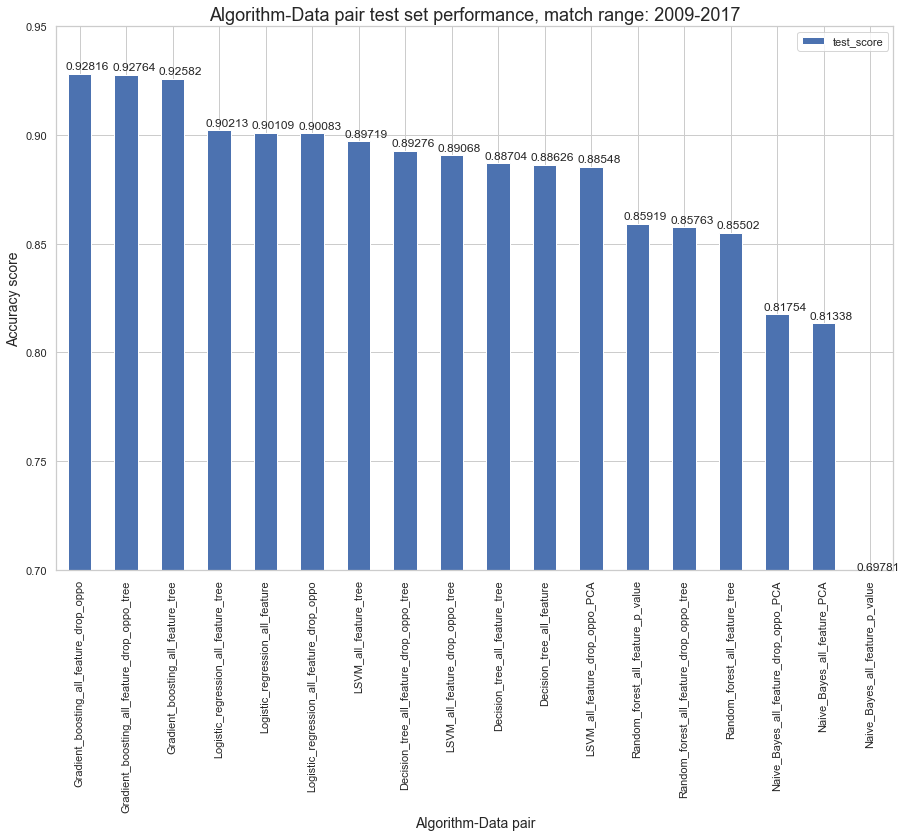

In [133]:
# plot the graph
fig, ax = plt.subplots(1,1,figsize=(15, 10))
all_test_df.plot(kind='bar', ax=ax)
ax.set_ylim([0.7,0.95])
ax.set_ylabel('Accuracy score', size=14)
ax.set_title('Algorithm-Data pair test set performance, match range: 2009-2017', size=18)
ax.set_xlabel('Algorithm-Data pair', size=14)
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), xy=(p.get_x()-0.05, p.get_height()+0.002))
plt.show()

Amazingly, gradient boosting model performed even better on test set, which reached more than 92% accuracy, but the drawback was again the lengthly training time, in the last part of our evaluation, we will use boostrapping method to see the consistency of our model performance, we will pick `Gradient_boosting_all_feature_drop_oppo_tree`, `Logistic_regression_all_feature_tree` and `LSVM_all_feature_tree` as our top3 model interms of accuracy and training time.

##### Bootstrapping to test model consistency
Bootstrapping is a test on random sampling with replacement, we will use it to test our model consistency, the process is basically take a random sample from our test set, use the model to predict the sample outcome and record the accuracy score, replace the sample and resample again to repeat the process, we will do this for 2000 times and see the distribution of accuracy score from random sampling, we will pick 500 samples from the test set for each iteration.

In [117]:
# define helper function
def bootstrapping(algo, data, index, kde=True):
    from sklearn.metrics import accuracy_score
    model = algorithm[algo](**all_params_df.loc[data, algo])
    model.fit(data_all_train[data], tennis_all_feature_clean_y_train)
    temp_data = pd.concat([data_all_test[data], tennis_all_feature_clean_y_test], axis=1) # concatenate the outcome to sample together
    score_list = []
    
    for i in range(len(index)):
        sample = temp_data.iloc[index[i]]
        score = accuracy_score(sample[0], model.predict(sample.drop([0], axis=1)))
        score_list.append(score)
    
    
    fig, ax = plt.subplots(1,1,figsize=(15,10))
    ax = sns.distplot(score_list, kde=kde)
    ax.set_title('Accuracy score distribution from test set', size=18)
    ax.set_xlabel('Score')
    if not kde:
        ax.set_ylabel('Count')
    name = algo + data
    plt.savefig(name+'.png')
    plt.show()
    score_mean = np.mean(score_list)
    score_std = np.std(score_list)
    print('Average test score from random sampling: {}'.format(score_mean))
    print('Standard deviation of test score from random sampling: {}'.format(score_std))
    print('CV% of test score from random sampling: {}%'.format(score_std/score_mean*100))
    
    return score_list # return all the score for further analysis 

# define a helper function to generate sample index
def sample_index(size=500, iteration=2000):
    index_dict = {}
    for i in range(iteration):
        index = tennis_all_feature_clean_y_test.sample(size, replace=True).index
        index_dict[i] = index
    return index_dict

We will use the function `sample_index` first to fix the index and use those for every model to ensure a fair game for comparison

In [118]:
index = sample_index()

##### Gradient_boosting_all_feature_drop_oppo_tree

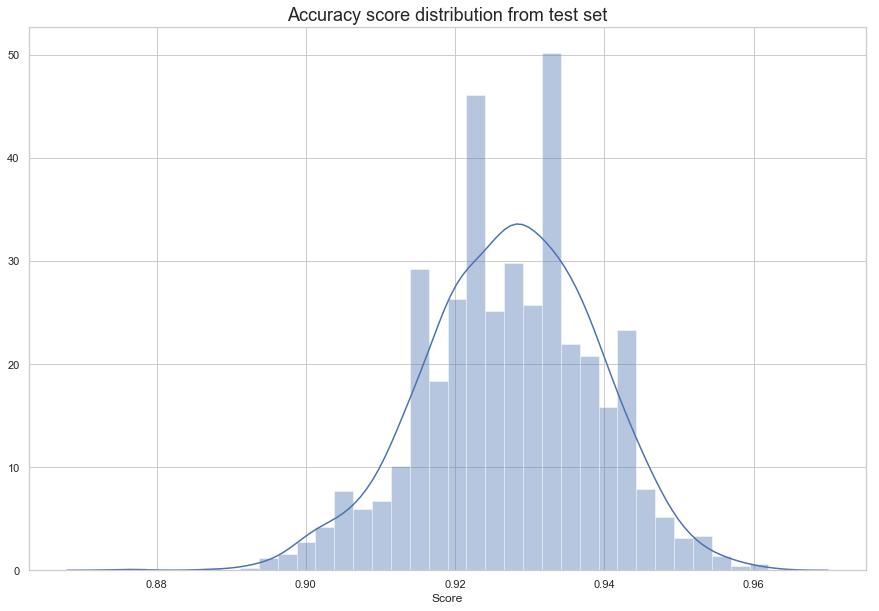

Average test score from random sampling: 0.927404
Standard deviation of test score from random sampling: 0.011490725999692081
CV% of test score from random sampling: 1.2390205347067818%
CPU times: user 40.6 s, sys: 445 ms, total: 41 s
Wall time: 43.1 s


In [119]:
%%time
gb_tree = bootstrapping('Gradient_boosting', 'all_feature_drop_oppo_tree', index=index)

##### Logistic_regression_all_feature_tree

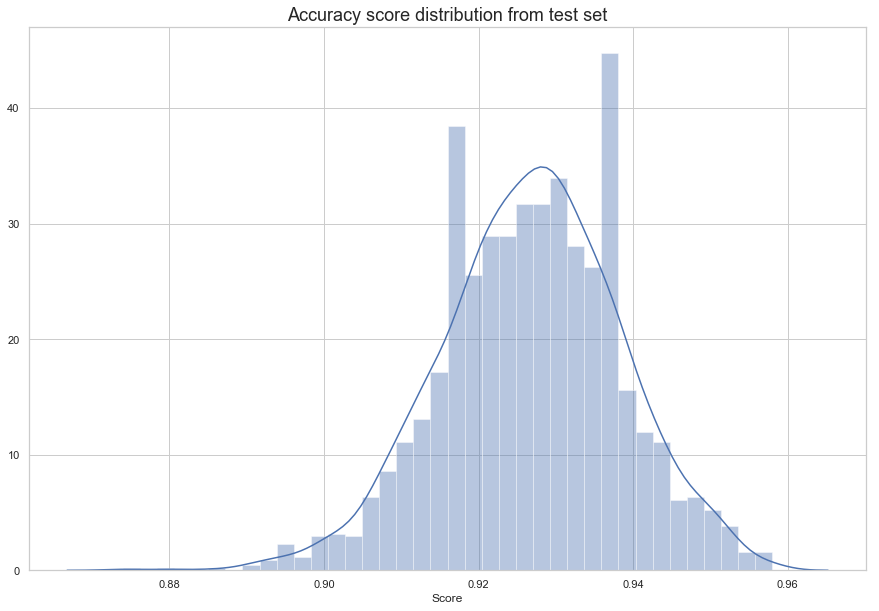

Average test score from random sampling: 0.926762
Standard deviation of test score from random sampling: 0.011630793438110729
CV% of test score from random sampling: 1.254992483303235%
CPU times: user 40.8 s, sys: 437 ms, total: 41.2 s
Wall time: 43.5 s


In [120]:
%%time
lg_tree = bootstrapping('Gradient_boosting', 'all_feature_tree', index=index)

##### LSVM_all_feature_tree

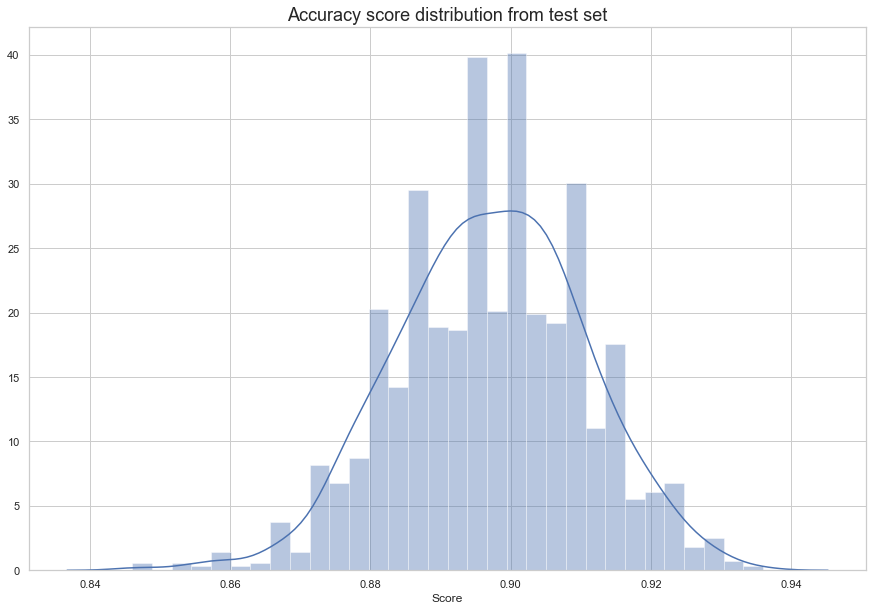

Average test score from random sampling: 0.897062
Standard deviation of test score from random sampling: 0.013465962869397803
CV% of test score from random sampling: 1.5011184142676652%
CPU times: user 49.6 s, sys: 2.67 s, total: 52.3 s
Wall time: 18.4 s


In [121]:
%%time
lsvm_tree = bootstrapping('LSVM', 'all_feature_tree', index=index)

We can see that the former two clearly outperformed the last algorithm-data pair, though the time it generated the result was a lot shorter. Finally, we will use the t-test to compare the former two to see if there exists significant difference between the score.

In [123]:
import scipy.stats as stats
print(stats.ttest_ind(gb_tree, lg_tree, equal_var=False))

Ttest_indResult(statistic=1.755626322789809, pvalue=0.07922881836306273)


The p-value is 7.9%, this is a relatively high value, suggesting the performance is about the same between `Gradient_boosting_all_feature_drop_oppo_tree` and `Logistic_regression_all_feature_tree`, if we really want to pick the best model, `Logistic_regression_all_feature_tree` has faster training time to claim the champion. 

#### mathces from 1991-2017, without `ranking_points` feature included.

In [134]:
all_score_no_pts_df = pd.DataFrame(all_score_no_pts, index=['all_feature_no_pts', 'all_feature_no_pts_drop_oppo', 
                'all_feature_no_pts_p_value', 'all_feature_no_pts_drop_oppo_p_value', 'all_feature_no_pts_tree',
                'all_feature_no_pts_drop_oppo_tree', 'all_feature_no_pts_PCA', 'all_feature_no_pts_drop_oppo_PCA'])
all_score_no_pts_df['Avg_score'] = all_score_no_pts_df.mean(axis=1)
all_score_no_pts_df

,Naive_Bayes,Logistic_regression,Decision_tree,Random_forest,LSVM,Gradient_boosting,Avg_score
all_feature_no_pts,0.656566,0.912521,0.886792,0.833238,0.876882,0.921479,0.847913
all_feature_no_pts_drop_oppo,0.666095,0.912521,0.887745,0.828092,0.881647,0.922622,0.849787
all_feature_no_pts_p_value,0.680961,0.860492,0.854774,0.854012,0.845054,0.881265,0.829426
all_feature_no_pts_drop_oppo_p_value,0.679245,0.858205,0.836478,0.838384,0.838956,0.873070,0.820723
all_feature_no_pts_tree,0.685153,0.911759,0.898609,0.867162,0.898609,0.920145,0.863573
all_feature_no_pts_drop_oppo_tree,0.666857,0.913474,0.897275,0.846198,0.902039,0.919764,0.857601
all_feature_no_pts_PCA,0.793787,0.878597,0.633124,0.740804,0.878978,0.740614,0.777651
all_feature_no_pts_drop_oppo_PCA,0.800076,0.883934,0.611588,0.743091,0.885458,0.743282,0.777905


In [149]:
all_params_no_pts_df = pd.DataFrame(all_params_no_pts, index=['all_feature_no_pts', 'all_feature_no_pts_drop_oppo', 
                'all_feature_no_pts_p_value', 'all_feature_no_pts_drop_oppo_p_value', 'all_feature_no_pts_tree',
                'all_feature_no_pts_drop_oppo_tree', 'all_feature_no_pts_PCA', 'all_feature_no_pts_drop_oppo_PCA'])
all_params_no_pts_df

,Naive_Bayes,Logistic_regression,Decision_tree,Random_forest,LSVM,Gradient_boosting
all_feature_no_pts,{'var_smoothing': 1e-11},"{'C': 0.01, 'penalty': 'l1'}","{'criterion': 'gini', 'max_depth': 7}","{'max_depth': 9, 'n_estimators': 500}","{'C': 0.01, 'penalty': 'l2'}",{'learning_rate': 0.1}
all_feature_no_pts_drop_oppo,{'var_smoothing': 1e-11},"{'C': 0.01, 'penalty': 'l1'}","{'criterion': 'gini', 'max_depth': 7}","{'max_depth': 9, 'n_estimators': 500}","{'C': 0.01, 'penalty': 'l2'}",{'learning_rate': 0.1}
all_feature_no_pts_p_value,{'var_smoothing': 1e-11},"{'C': 0.01, 'penalty': 'l1'}","{'criterion': 'gini', 'max_depth': 5}","{'max_depth': 9, 'n_estimators': 500}","{'C': 0.01, 'penalty': 'l2'}",{'learning_rate': 0.1}
all_feature_no_pts_drop_oppo_p_value,{'var_smoothing': 1e-11},"{'C': 0.1, 'penalty': 'l1'}","{'criterion': 'entropy', 'max_depth': 5}","{'max_depth': 9, 'n_estimators': 500}","{'C': 0.01, 'penalty': 'l2'}",{'learning_rate': 0.05}
all_feature_no_pts_tree,{'var_smoothing': 1e-11},"{'C': 0.1, 'penalty': 'l1'}","{'criterion': 'gini', 'max_depth': 7}","{'max_depth': 9, 'n_estimators': 500}","{'C': 0.01, 'penalty': 'l2'}",{'learning_rate': 0.1}
all_feature_no_pts_drop_oppo_tree,{'var_smoothing': 1e-11},"{'C': 0.1, 'penalty': 'l1'}","{'criterion': 'gini', 'max_depth': 7}","{'max_depth': 9, 'n_estimators': 500}","{'C': 0.01, 'penalty': 'l2'}",{'learning_rate': 0.1}
all_feature_no_pts_PCA,{'var_smoothing': 1e-11},"{'C': 0.1, 'penalty': 'l2'}","{'criterion': 'gini', 'max_depth': 3}","{'max_depth': 9, 'n_estimators': 500}","{'C': 0.01, 'penalty': 'l2'}",{'learning_rate': 0.5}
all_feature_no_pts_drop_oppo_PCA,{'var_smoothing': 1e-11},"{'C': 0.1, 'penalty': 'l2'}","{'criterion': 'gini', 'max_depth': 3}","{'max_depth': 9, 'n_estimators': 500}","{'C': 0.01, 'penalty': 'l2'}",{'learning_rate': 0.5}


In [136]:
all_score_no_pts_df.mean().sort_values(ascending=False)

Logistic_regression    0.891438
LSVM                   0.875953
Gradient_boosting      0.865280
Avg_score              0.828072
Random_forest          0.818873
Decision_tree          0.813298
Naive_Bayes            0.703593
dtype: float64

In [137]:
all_score_no_pts_df['Avg_score'].sort_values(ascending=False)

all_feature_no_pts_tree                 0.863573
all_feature_no_pts_drop_oppo_tree       0.857601
all_feature_no_pts_drop_oppo            0.849787
all_feature_no_pts                      0.847913
all_feature_no_pts_p_value              0.829426
all_feature_no_pts_drop_oppo_p_value    0.820723
all_feature_no_pts_drop_oppo_PCA        0.777905
all_feature_no_pts_PCA                  0.777651
Name: Avg_score, dtype: float64

We can see that logistic and gradient boosting in general has a higher accuracy score than other algorithms, both are able to reach over 90%, however PCA data did not perform well in gradient boosting and the variance of logistic regression is relatively small between different datasets.

Our next step is to use the best three in each algorithm on our test set to see how it performs on out of sample data, we will define a helper function to assist our goal.

##### Test set performance

In [138]:
# test set data dictionary
data_all_test_no_pts = {'all_feature_no_pts': tennis_all_feature_no_pts_clean_X_test, 
                         'all_feature_no_pts_drop_oppo': tennis_all_feature_no_pts_clean_drop_oppo_X_test,
                         'all_feature_no_pts_p_value': tennis_all_feature_no_pts_clean_X_test_p_value, 
                         'all_feature_no_pts_drop_oppo_p_value': tennis_all_feature_no_pts_clean_drop_oppo_X_test_p_value,
                         'all_feature_no_pts_tree': tennis_all_feature_no_pts_clean_X_test_tree, 
                         'all_feature_no_pts_drop_oppo_tree': tennis_all_feature_no_pts_clean_drop_oppo_X_test_tree,
                         'all_feature_no_pts_PCA': tennis_all_feature_no_pts_clean_X_test_PCA, 
                         'all_feature_no_pts_drop_oppo_PCA': tennis_all_feature_no_pts_clean_drop_oppo_X_test_PCA}

# algorithm dictionary
algorithm = {'Naive_Bayes': GaussianNB, 'Logistic_regression': LogisticRegression, 
        'Decision_tree': DecisionTreeClassifier, 'Random_forest': RandomForestClassifier, 
        'LSVM': LinearSVC, 'Gradient_boosting': GradientBoostingClassifier}

# test score dictionary
test_score_no_pts = {}

In [139]:
# define helper function
def test_accuracy_no_pts(algo, top=2): # use the top 2 algorithms as default
    from sklearn.metrics import accuracy_score
    rank = all_score_no_pts_df.rank(method='first', ascending=False) # get the ranking of data in each algorithm
    for data in rank[algo][rank[algo] <= top].index: # pick only the highest two
        model = algorithm[algo](**all_params_no_pts_df.loc[data, algo]) # fit the model with the best parameters
        model.fit(data_all_train_no_pts[data], tennis_all_feature_no_pts_clean_y_train)
        score = accuracy_score(tennis_all_feature_no_pts_clean_y_test, model.predict(data_all_test_no_pts[data]))
        test_score_no_pts[algo+'_'+data] = round(score,5)

In [140]:
for algo in algorithm:
    test_accuracy_no_pts(algo, top=3)

In [142]:
# create a dataframe to list all the score
all_test_no_pts_df = pd.DataFrame(test_score_no_pts, index=['test_score'])
all_test_no_pts_df = all_test_no_pts_df.T.sort_values(by='test_score', ascending=False)
all_test_no_pts_df

,test_score
Gradient_boosting_all_feature_no_pts,0.90800
Gradient_boosting_all_feature_no_pts_drop_oppo,0.90711
Gradient_boosting_all_feature_no_pts_tree,0.90578
Logistic_regression_all_feature_no_pts_drop_oppo,0.90267
Logistic_regression_all_feature_no_pts,0.90222
Logistic_regression_all_feature_no_pts_drop_oppo_tree,0.90133
LSVM_all_feature_no_pts_tree,0.89911
LSVM_all_feature_no_pts_drop_oppo_tree,0.89422
LSVM_all_feature_no_pts_drop_oppo_PCA,0.88178
Decision_tree_all_feature_no_pts_drop_oppo,0.88133


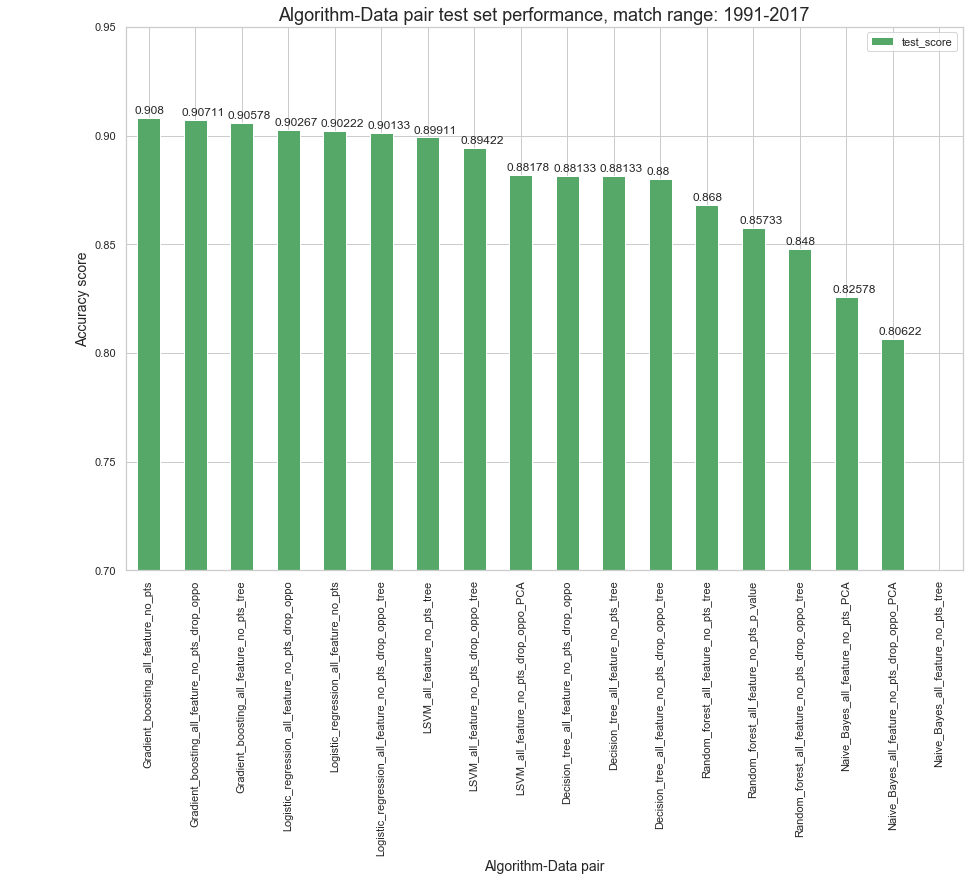

In [143]:
# plot the graph
fig, ax = plt.subplots(1,1,figsize=(15, 10))
all_test_no_pts_df.plot(kind='bar', ax=ax, color='g')
ax.set_ylim([0.7,0.95])
ax.set_ylabel('Accuracy score', size=14)
ax.set_title('Algorithm-Data pair test set performance, match range: 1991-2017', size=18)
ax.set_xlabel('Algorithm-Data pair', size=14)
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), xy=(p.get_x()-0.05, p.get_height()+0.002))
plt.show()

We can see that in general it performed worse than data with `ranking_points`, the reason behind that might be the range of data(1991-2017) was a lot longer than previously, making it harder to generalize. We will pick `Gradient_boosting_all_feature_no_pts_tree`, `Logistic_regression_all_feature_no_pts_drop_oppo` and `LSVM_all_feature_no_pts_tree` to compare further with bootstrapping as before to test the consistency.

##### Bootstrapping to test model consistency
We will repeat the process on the data without `ranking_points` features.

In [151]:
# define helper function
def bootstrapping_no_pts(algo, data, index, kde=True):
    from sklearn.metrics import accuracy_score
    model = algorithm[algo](**all_params_no_pts_df.loc[data, algo])
    model.fit(data_all_train_no_pts[data], tennis_all_feature_no_pts_clean_y_train)
    temp_data = pd.concat([data_all_test_no_pts[data], tennis_all_feature_no_pts_clean_y_test], axis=1) # concatenate the outcome to sample together
    score_list = []
    
    for i in range(len(index)):
        sample = temp_data.iloc[index[i]]
        score = accuracy_score(sample[0], model.predict(sample.drop([0], axis=1)))
        score_list.append(score)
    
    
    fig, ax = plt.subplots(1,1,figsize=(15,10))
    ax = sns.distplot(score_list, kde=kde)
    ax.set_title('Accuracy score distribution from test set', size=18)
    ax.set_xlabel('Score')
    if not kde:
        ax.set_ylabel('Count')
    name = algo + data
    plt.savefig(name+'.png')
    plt.show()
    score_mean = np.mean(score_list)
    score_std = np.std(score_list)
    print('Average test score from random sampling: {}'.format(score_mean))
    print('Standard deviation of test score from random sampling: {}'.format(score_std))
    print('CV% of test score from random sampling: {}%'.format(score_std/score_mean*100))
    
    return score_list # return all the score for further analysis 

# define a helper function to generate sample index
def sample_index_no_pts(size=300, iteration=2000):
    index_dict = {}
    for i in range(iteration):
        index = tennis_all_feature_no_pts_clean_y_test.sample(size, replace=True).index
        index_dict[i] = index
    return index_dict

In [147]:
index = sample_index_no_pts()

##### Gradient_boosting_all_feature_no_pts_tree

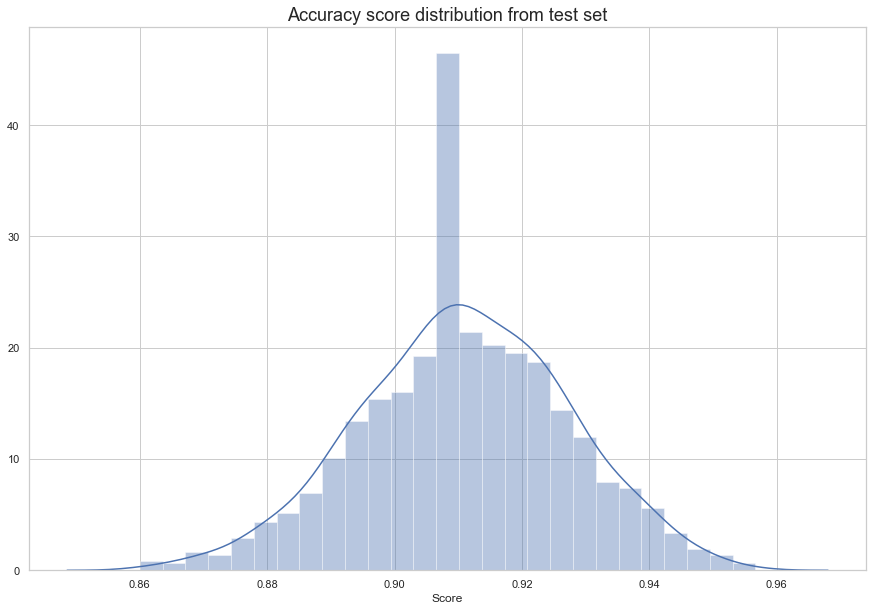

Average test score from random sampling: 0.9108666666666666
Standard deviation of test score from random sampling: 0.016410836528207684
CV% of test score from random sampling: 1.8016727506632166%
CPU times: user 25.1 s, sys: 1.09 s, total: 26.2 s
Wall time: 26 s


In [152]:
%%time
gb_tree_2 = bootstrapping_no_pts('Gradient_boosting', 'all_feature_no_pts_drop_oppo_tree', index=index)

##### Logistic_regression_all_feature_no_pts_drop_oppo

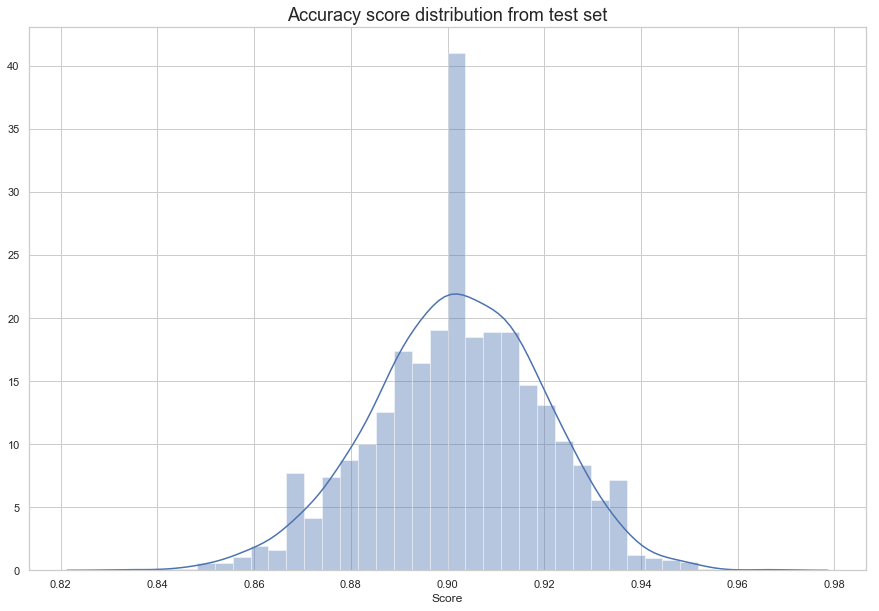

Average test score from random sampling: 0.9020416666666667
Standard deviation of test score from random sampling: 0.017714195108255226
CV% of test score from random sampling: 1.9637890091834513%
CPU times: user 1min 18s, sys: 7.07 s, total: 1min 25s
Wall time: 24.5 s


In [155]:
%%time
lg_2 = bootstrapping_no_pts('Logistic_regression', 'all_feature_no_pts_drop_oppo', index=index)

##### LSVM_all_feature_no_pts_tree

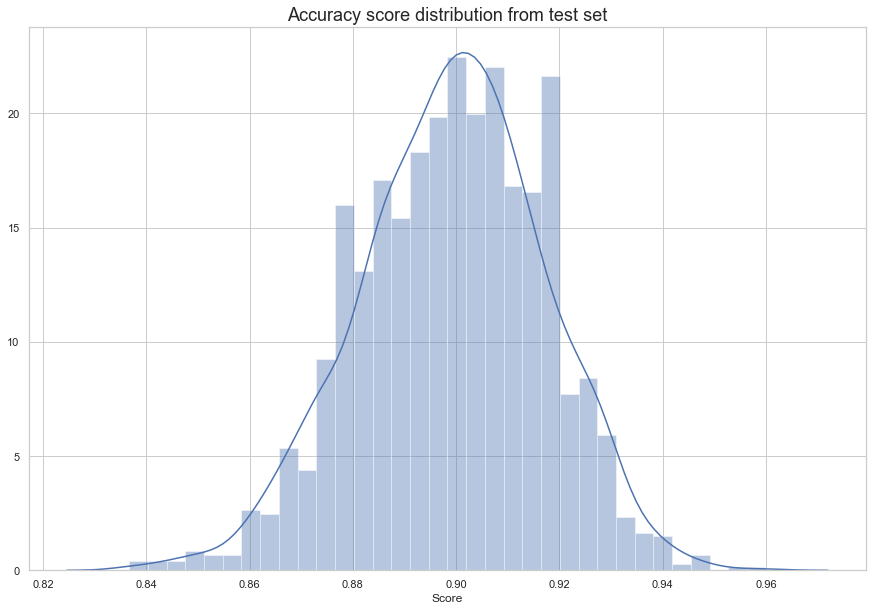

Average test score from random sampling: 0.8992033333333332
Standard deviation of test score from random sampling: 0.01788602154383883
CV% of test score from random sampling: 1.9890964457989293%
CPU times: user 39.3 s, sys: 1.86 s, total: 41.1 s
Wall time: 12.1 s


In [156]:
%%time
lsvm_tree_2 = bootstrapping_no_pts('LSVM', 'all_feature_no_pts_tree', index=index)

We can clearly see the winner here: `Gradient_boosting_all_feature_no_pts_tree`, which has more than 91% accuracy and more consistent compare to the other two, it looks like `Gradient boosting` with `all_feature_no_pts_tree` is a good pair together as they also performed well in data with `ranking_points` we showed previously.

### Deep learning model
Now it is time to try some deep learning model to see whether it has better or worse performance compare to traditional machine learning model.

#### RNN model
We will now try the deep learning model, as we mentioned before, we need to reshape our data into (m, t, n) format, where m means the number of training examples, t stands for timestep and n stands for number of features in one example, our goal is to predict the outcome of the current match played by player 1 and 2, the training examples include different `timestep`, each `timestep` represents one previous match that player 1 and 2 played, we have included 10 matches like we did in traditional machine learning model, the difference is we use flatten previous 10 matches stats and use them all at once for traditional ML model, whereas we feed the 10th match(1st timestep) first in RNN, then 9th(2nd timestep) match, 8th(3rd timestep) match...and so on in RNN model, each output of previous `timestep` is used for the current `timestep` so all the sequential data is connected together. Note that we will use "Many-to-one" as the layout of our RNN model(showing below), where we only have one output y as the match outcome.

![RNN](https://raw.githubusercontent.com/george1577/Thinkful_Data_Science/master/Capstone%20project/Capstone%20project%202/Images/RNN_1.png)

#### SimpleRNN vs LSTM
RNN is mostly used in sequential model like text prediction, for example, given a sentence and RNN is able to predict what the most possible next sentence will be. Simple RNN model is not commonly use due to the [vanishing gradient problem](https://www.superdatascience.com/blogs/recurrent-neural-networks-rnn-the-vanishing-gradient-problem/), the weighth of the further `timestep` will approach near zero as the sequence gets longer and longer. To solve this, [researcher](http://www.bioinf.jku.at/publications/older/2604.pdf) came up with the LSTM(Long Short-Term Memory) networks, which introduced the input gate, the forget gate and the output gate as shown below. In this way RNN is able to keep the memory from the further `timestep` and update the cell if necessary. In out application, we might actually need the RNN to put "less weight" on the match that was played relatively long time ago, since those are less likely to affect the outcome of the current match, in this part we will apply both simple RNN as well as LSTM to compare if it makes any difference. We will also use the grid search like we did in traditional machine learning model to find out the best hyperparameters.

#### Import packages

In [70]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier 

Using TensorFlow backend.


#### Prepare training examples
Due to the required format of (m, t, n) for RNN, we will only be using `tennis_all_feature_clean_X_train`,  `tennis_all_feature_drop_oppo_clean_X_train`,  `tennis_all_feature_no_pts_clean_X_train` and `tennis_all_feature_no_pts_drop_oppo_clean_X_train`to train our model, we will not be using any processed training examples such as model-based feature selection since they do not have the same feature size for every timestep.

In [71]:
print(tennis_all_feature_clean_X_train.shape)
print(tennis_all_feature_clean_drop_oppo_X_train.shape)
print(tennis_all_feature_no_pts_clean_X_train.shape)
print(tennis_all_feature_no_pts_clean_drop_oppo_X_train.shape)

(8962, 2280)
(8962, 1540)
(5247, 2220)
(5247, 1500)


In [72]:
print(tennis_all_feature_clean_X_test.shape)
print(tennis_all_feature_no_pts_clean_X_test.shape)

(3842, 2280)
(2250, 2220)


In [157]:
# reshape training and testing examples, for matches between 2009-2017
X_train = tennis_all_feature_clean_X_train.values.reshape(8962, 10, 228)
X_test = tennis_all_feature_clean_X_test.values.reshape(3842, 10, 228)
X_train_drop = tennis_all_feature_clean_drop_oppo_X_train.values.reshape(8962, 10, 154)
X_test_drop = tennis_all_feature_clean_drop_oppo_X_test.values.reshape(3842, 10, 154)
y_train = tennis_all_feature_clean_drop_oppo_y_train.values.reshape(8962, 1)
y_test = tennis_all_feature_clean_drop_oppo_y_test.values.reshape(3842, 1)

In [158]:
X_train_no_pts = tennis_all_feature_no_pts_clean_X_train.values.reshape(5247, 10, 222)
X_test_no_pts = tennis_all_feature_no_pts_clean_X_test.values.reshape(2250, 10, 222)
X_train_no_pts_drop = tennis_all_feature_no_pts_clean_drop_oppo_X_train.values.reshape(5247, 10, 150)
X_test_no_pts_drop = tennis_all_feature_no_pts_clean_drop_oppo_X_test.values.reshape(2250, 10, 150)
y_train_no_pts = tennis_all_feature_no_pts_clean_drop_oppo_y_train.values.reshape(5247, 1)
y_test_no_pts = tennis_all_feature_no_pts_clean_drop_oppo_y_test.values.reshape(2250, 1)

##### Simple RNN
We will first try the simpleRNN model and tune up some hyperparameters to see if we could find an ideal combination, we will add another dense layer between the input and output layer to see if it does any help to the prediction. The output activation function we use here will be [`softmax`](https://en.wikipedia.org/wiki/Softmax_function), this function is commonly used in categorical output and it will assign sort of probability of each output with the total equals 1, this is ideal for our ultimate goal of predicting the winning percentage of a certain player in order to apply on the real world to set up the odds.

Before that, we need to reshape our output variable y since the output of softmax function requires at least 2 units, we will add another opposite outcome column to make the output shape as (n, 2), where n stands for the number of examples.

##### matches from 2009-2017, with `ranking_points` feature included.

In [163]:
y_train.shape

(8962, 1)

In [164]:
# reshape y_train and y_test to (n, 2)
y_train_oppo = np.where(y_train == 1, 0, 1)
y_train_softmax = np.concatenate([y_train, y_train_oppo], axis=1)

In [165]:
# check the shape
y_train_softmax.shape

(8962, 2)

We will start with hyperparameter tuning for RNN, but we will not do it all at once due to limited computation resource, we will tune them separately, this might not get us the most ideal hyperparameters combination, but good enough for our model.

`batch_size` and `epochs`

In [169]:
# define model function to feed in KerasClassifier
def simpleRNN(n=228):
    # create model
    model = Sequential()
    model.add(SimpleRNN(32, input_shape=(10, n)))
    # add another dense layer
    model.add(Dense(2, activation='relu'))
    # add the final layer
    model.add(Dense(2, activation='softmax'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [170]:
# use X_train and y_train loaded above
np.random.seed(1009)
batch_size = [10, 20, 40]
epochs = [5, 10, 15]
param_grid = dict(batch_size=batch_size, epochs=epochs)
model = KerasClassifier(build_fn=simpleRNN, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, y_train_softmax)
print(f'Best accuracy score: {grid.best_score_}, best parameters: {grid.best_params_}')

Best accuracy score: 0.8774827032436672, best parameters: {'batch_size': 20, 'epochs': 10}


Next we will tune `training optimization algorithm` by using batch_size = 20 and epochs = 10.

In [172]:
# define model function to feed in KerasClassifier
def simpleRNN(n=228, optimizer='Adam'):
    # create model
    model = Sequential()
    model.add(SimpleRNN(32, input_shape=(10, n)))
    # add another dense layer
    model.add(Dense(2, activation='relu'))
    # add the final layer
    model.add(Dense(2, activation='softmax'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [173]:
np.random.seed(1009)
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
model = KerasClassifier(build_fn=simpleRNN, batch_size=20, epochs=10, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, y_train_softmax)
print(f'Best accuracy score: {grid.best_score_}, best parameters: {grid.best_params_}')

Best accuracy score: 0.8785985254717309, best parameters: {'optimizer': 'Adagrad'}


Next we will tune `init_mode` by fixing batch_size = 20, epochs = 10 and optimizer = 'Adagrad'

In [174]:
def simpleRNN(n=228, init_mode='uniform'):
    # create model
    model = Sequential()
    model.add(SimpleRNN(32, input_shape=(10, n)))
    # add another dense layer
    model.add(Dense(2, activation='relu', kernel_initializer=init_mode))
    # add the final layer
    model.add(Dense(2, activation='softmax', kernel_initializer=init_mode))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='Adagrad', metrics=['accuracy'])
    return model

In [175]:
np.random.seed(1009)
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 
             'he_uniform']
param_grid = dict(init_mode=init_mode)
model = KerasClassifier(build_fn=simpleRNN, batch_size=20, epochs=10, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, y_train_softmax)
print(f'Best accuracy score: {grid.best_score_}, best parameters: {grid.best_params_}')

Best accuracy score: 0.8826154852998865, best parameters: {'init_mode': 'lecun_uniform'}


Next we will tune number of `nuerons` by fixing  batch_size = 20, epochs = 10, optimizer = 'Adagrad' and init_mode = 'lecun_uniform'.

In [179]:
def simpleRNN(n=228, neurons=2):
    # create model
    model = Sequential()
    model.add(SimpleRNN(32, input_shape=(10, n)))
    # add another dense layer
    model.add(Dense(neurons, activation='relu', kernel_initializer='lecun_uniform'))
    # add the final layer
    model.add(Dense(2, activation='softmax', kernel_initializer='lecun_uniform'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='Adagrad', metrics=['accuracy'])
    return model

In [ ]:
np.random.seed(1009)
neurons = [1, 2, 4, 8, 16, 32, 64]
param_grid = dict(neurons=neurons)
model = KerasClassifier(build_fn=simpleRNN, batch_size=20, epochs=10, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, y_train_softmax)
print(f'Best accuracy score: {grid.best_score_}, best parameters: {grid.best_params_}')

In [74]:
# define the opposite array of y_train
y_train_oppo = np.where(y_train == 1, 0, 1)
y_train_softmax = np.concatenate((y_train, y_train_oppo), axis=1)

In [75]:
# define model function to feed in KerasClassifier
def simpleRNN(n=228):
    # create model
    model = Sequential()
    model.add(SimpleRNN(32, input_shape=(10, n)))
    # add another dense layer
    #model.add(Dense(neurons, activation='relu'))
    # add the final layer, need two outputs
    model.add(Dense(2, activation='softmax'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [76]:
# use X_train and y_train loaded above
np.random.seed(1009)

batch_size = [10, 20, 40]
epochs = [5, 10, 15]
#dropout = [0, 0.1, 0.2, 0.3]
#neurons = [2, 4, 8, 16, 32, 64]
param_grid = dict(batch_size=batch_size, epochs=epochs)
model = KerasClassifier(build_fn=simpleRNN, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, y_train_softmax)
print(f'Best accuracy score: {grid.best_score_}, best parameters: {grid.best_params_}')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Best accuracy score: 0.8764784613828313, best parameters: {'batch_size': 20, 'epochs': 5}


In [37]:
np.random.seed(1009)
neurons = [2, 4, 8, 16, 32, 64]
param_grid = dict(neurons=neurons)
model = KerasClassifier(build_fn=simpleRNN, epochs=5, batch_size=20, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print(f'Best accuracy score: {grid.best_score_}, best parameters: {grid.best_params_}')

Best accuracy score: 0.8797143471677291, best parameters: {'neurons': 20}


In [ ]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM